## Preprocessing

In the previous notebook we extracted the time series for different ROIs. However, we are now going to take a step back from that and preprocess our data before we can move on with the analysis.


A key point in the analysis of brain image is to have a solid preprocessed image. The preprocessing inclues all the steps that are taken to improve our data and prepare it for statistical analysis. Usual preprocessing steps include: 
 * Corrections for head movement during scanning 
 * Slice corrections
 * Detection of artifacts during scanning
 * Normalisation of structural image into MNI space
 * Filtering

We are lucky that a few of this steps have been already performed on the dataset we are using. In this notebook we are going to perform a few important preprocessing steps. To do this, we will use a library called *nipype*, so make sure it is installed in your enviroment.

*Nipype* is a really nice library that allows you to use different functions from different existing neuroimaging softwares.


As usual, first we need to load the required Python libraries. Again, make sure you have them all installed in your virtual enviroment.

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline  
from IPython.display import Image

from nipype.interfaces.fsl import Info, GLM, MeanImage, BinaryMaths, FSLCommand, TemporalFilter
from nipype.interfaces.utility import IdentityInterface, Function
from nipype.interfaces.ants import ApplyTransforms
from nipype.pipeline.engine import MapNode, Node, Workflow
from nipype.interfaces.io import DataSink, DataGrabber


**Note**: If you are having problems loading nipype you shoul do the following:
- install ipykernel on your virtual enviroment by doing:
`conda install ipykernel`
- run in the terminal (change my-virtualenv-name):
`python -m ipykernel install --user --name=my-virtualenv-name`
- Then inside your notebook click on `Kernel>Change Kernel>my-virtualenv-name`

If you are not having problems than just ignore this.


Then set up the paths to our data and important variables. You should change them accordingly, so that they match your paths.

In [2]:
# Settings
base_path_data = os.path.join(os.path.sep, 'group', 'dynamics', 'HCP')
data_dir = os.path.join(os.path.sep, 'home', 'jdafflon', 'code', 'msc_project', 'patrycja')
data_out_dir = os.path.join(data_dir, 'data_out', 'test')
data_in_dir = os.path.join(data_dir, 'data_in')


LR_or_RL = 'rfMRI_REST2_LR'
subjects_list = ['100307']
FSLCommand.set_default_output_type('NIFTI_GZ')


segmentation_image_path = os.path.join( os.path.sep, 'group', 'dynamics', 'scz_dynamics', 'ucla-la5', 'data_in', 'voi_extraction', 'seg_aparc_82roi_2mm.nii.gz')
lookuptable_file_path = os.path.join(os.path.sep, 'group', 'dynamics', 'scz_dynamics', 'ucla-la5', 'data_in', 'voi_extraction','LookupTable')
non_preprocessed_image_path = os.path.join(base_path_data, subjects_list[0], 'MNINonLinear', 'Results', LR_or_RL, 'rfMRI_REST2_LR.nii.gz')

In [17]:
subject = subjects_list[0]

We will now do some corrections for motion on the dataset. Subject head movement, during the experiment is a major source of artefact in fMRI data. Changes in pixel intensity at the edges of the brain, upon even slight movement, can be far greater than the BOLD activation response. It is common therefore in fMRI data analysis to perform some correction which reduces this effect.

Luckly, the motion parameters have already been calculated for us, so all we need to do is load them. And check the shape, for good practice.

In [3]:
# Load motion correction file
motion_parameter_file = os.path.join(base_path_data, '100307', 'MNINonLinear', 'Results', 'rfMRI_REST2_LR', 'Movement_Regressors.txt')
motion_parameter = np.genfromtxt(motion_parameter_file)
motion_parameter.shape

(1200, 12)

## Nipype

Now we will start using nipype. There are different ways of using nipype, here we will create a workflow where each step of our preprocessing pipeline will be composed by a node. Therefore we will need to create the basics for your Nodes in nipype.

If you want to get a better insight how a piple is create in nipype you can take a look [here]( http://miykael.github.io/nipype-beginner-s-guide/firstSteps.html). But I will save you the work of creating a pipeline and do everything here.


### Temporal Filtering

Before we go into more details of how to run the preprocessing pipeline in nipype. Let's take a look into the temporal filtering, which is an important step in the preprocessing. 

Temporal Filtering allow us to imporve the signal-to-noise ratio of our data. It not only removes high frequency fluctuations but also scanner drifts from the data.

There are mainly three types of filters: **high-pass filters**, **low-pass filters** and **band-pass filters**.
While high-pass filtering will remove low frequency variations in the data, the low-pass filter will remove high frequency in the data. The band-pass filter will remove the frequecies that are outside the specified range.

For this preprocessing we wil perform a band-pass filter.
To do this we will need to find the TR of our data. The TR corresponds to the repetition time of our MRI sequence and can be read up from the data.

**Question:** Find out the TR of the current dataset. Hint: Try to call the function `fslinfo` on your resting state image or alternatively you can look up the documentation on the HCP website (where we have downloaded the data).

### Band-pass filter

Spontaneous activity have been observed in the resting state in a low frequency range of [0.01–0.1] Hz. Therefore, we will perform a banpass filter to filter only the frequencies that in the range that we are interested in. Take a look at this [paper](http://www.sciencedirect.com/science/article/pii/S1053811916307881). It will give you an introduction to dynamic Functional Connectivity which we will use in the next notebook and in idea of what are those spontaneous fluctuations.

Let's get back to our analysis. Let's say we want to create a band-pass filter between 0.04 Hz and 0.1. How can we do it?

This example assumes that the TR is 2, which is **not** the case for this dataset but using the TR information you got from your data set you should be able to calcultate it.

* Lower band of the banp-pass filter:

low_pass = $\frac{\frac{1}{TR}}{filter in Hz} = \frac{\frac{1}{2s}}{0.04 1/s} = 12.5 $
However, as the fsl temporal filter takes the sigma HWHM and not the FWHM, we will need to divide this value by 2.
low_pass_filter = $\frac{12.5}{2} = 6.25$

* Higher band of the band-pass filter:
A similar calculation is one using the *high pass filter* just change the 0.04 Hz for 0.1 Hz.

In [4]:
# The TR for this dataset is 0.72 s
TR = 0.72
# TR = ??? (in seconds)
highpass_hz = 0.04
lowpass_hz = 0.1

lowpass_sigma = round((1/TR)/(lowpass_hz * 2),2)
highpass_sigma = round((1/TR)/(highpass_hz * 2),2)

print('low-pass sigma:', lowpass_sigma)
print('high-pass sigma:', highpass_sigma)

('low-pass sigma:', 6.94)
('high-pass sigma:', 17.36)


Because we might want to change this boundary in the future we are going to define a function that takes a list of frequencies as input for the preprocessing.

In [5]:
aparc_lookuptable = os.path.join(data_in_dir, 'aparcLookupTable')
lookuptable = np.genfromtxt(aparc_lookuptable,
                            names='intensity, regions',
                            dtype=None,
                            delimiter=','
                            )

def get_file(in_file):
    """
    ApplyTransforms output is a list. This function gets the path to warped file
    from the import generated list
    """
    path2file = in_file[0]
    return path2file


def extract_wm_csf(segmented_image, lookuptable, input_file, output_basepath, subjects):
    import os
    import nibabel as nib
    import numpy as np
    
    subjects = [subjects]
    for subject in subjects:
        segmented_image_nib = nib.load(segmented_image)
        segmented_image_data = segmented_image_nib.get_data()

        # Generate the output folder. Specify input filename
        subject_path = os.path.join(output_basepath, str(subject))
        if not os.path.exists(subject_path):
            os.makedirs(subject_path)
        image = nib.load(input_file)
        image_data = image.get_data()
        ntpoints = image_data.shape[3]
        avg = np.zeros((lookuptable['intensity'].shape[0], ntpoints))
                         
        for region in range(len(lookuptable)):
            intensity = lookuptable['intensity'][region]
            boolean_mask = np.where(segmented_image_data == intensity)
            for t in range(ntpoints):
                data = image_data[:, :, :, t]
                data = data[boolean_mask[0], boolean_mask[1], boolean_mask[2]]
                avg[region, t] = data.mean()
        avg = avg.T
        np.savetxt(os.path.join(subject_path, 'wm_csf_signal.txt'),
                   avg, delimiter=' ')
        return avg

def concatenate_design(motion_parameters, wm_csf_design_data, output_basepath, subjects):
    import numpy as np
    import os
    
    subjects = [subjects]
    for subject in subjects:
        # Generate the output folder. Specify input filename
        subject_path = os.path.join(output_basepath, str(subject))
        if not os.path.exists(subject_path):
            os.makedirs(subject_path)
        motion_parameters_data = np.genfromtxt(motion_parameters)
        glm_design = np.concatenate((motion_parameters_data, wm_csf_design_data), axis=1)
        design_path = os.path.join(subject_path, 'glm_desing.txt')
        np.savetxt(design_path, glm_design, delimiter=' ')
    return design_path

In [6]:
def preprocessing_pipeline(lowpass_sigma_list ,highpass_sigma_list, subjects_list, lookuptable, data_out_dir):
    # Create input node. This is where you are specify where you data comes from.
    infosource = Node(interface=IdentityInterface(fields=['subject_id']), name='InfoSource')
    infosource.iterables = ('subject_id', subjects_list)
    datasource = Node(interface=DataGrabber(infields=['subject_id'],
                 outfields=['epi', 'aparc_trans', 'aparc', 'motion_parameters']), name='datasource')
    datasource.inputs.base_directory = base_path_data
    datasource.inputs.template = '*'
    datasource.inputs.sort_filelist = True
    datasource.inputs.field_template = dict(epi=os.path.join('%s', 'MNINonLinear', 'Results',
                                                             LR_or_RL, 'rfMRI_REST2_LR.nii.gz'), 
                                            aparc_trans=os.path.join('%s', 'MNINonLinear', 'xfms',
                                                               'acpc_dc2standard.nii.gz'),
                                            aparc=os.path.join('%s', 'MNINonLinear', 'aparc+aseg.nii.gz'),
                                            motion_parameters=os.path.join('%s', 'MNINonLinear', 'Results', LR_or_RL, 'Movement_Regressors.txt') 
                                            )

    # Create data sink. This is where your data is going to be saved.
    data_sink = Node(DataSink(), name='DataSink')
    data_sink.inputs.base_directory = os.path.join(data_out_dir, 'preprocessing_out')
    substitutions = [('_subject_id', ''),
                     ('_warpall0', 'warpall')]


    # NODE 1:
    # We will use a General Linear Model (GLM) to regress activity related to movement.
    # To do this we will use the motion parametrs we have from our dataset.
    glm = Node(GLM(), name='GLM')
    glm.inputs.demean = True
    glm.inputs.out_res_name = 'residuals.nii.gz' 
    glm.inputs.out_file = 'glm_betas.nii.gz'

    # Node 2:
    # This node performs the temporal filtering.
    tmp_filt = Node(TemporalFilter(), name='TemporalFilter')
    tmp_filt.iterables = [('lowpass_sigma', lowpass_sigma_list), 
                          ('highpass_sigma', highpass_sigma_list)]

    # Node
    # Register aparc image to standart MNI space
    warpall = MapNode(ApplyTransforms(), name='warpall', iterfield=['input_image'])
    warpall.inputs.args = '--float'
    warpall.inputs.reference_image = Info.standard_image('MNI152_T1_2mm.nii.gz') # reference image space that you wish to warp INTO
    warpall.inputs.input_image_type = 3 # define input image type scalar(1), vector(2), tensor(3)
    warpall.inputs.interpolation = 'Linear'
    warpall.inputs.terminal_output = 'file' # writes output to file
    
    #Node
    # Get file from list that is generated by ApplyTransforms
    warpfile = Node(name='get_warp_file',
                    interface=Function(input_names=['in_file'],
                                       output_names=['out_file'],
                                       function=get_file)
                    )
    
    # Node 3:
    # Obtain out CSF and WM signal
    wm_csf = Node(name='wm_csf',
                  interface=Function(input_names=['subjects', 'input_file', 'segmented_image', 'lookuptable',
                                                  'output_basepath'],
                                     output_names=['wm_csf_design'],
                                     function=extract_wm_csf))
    wm_csf.inputs.lookuptable = lookuptable
    wm_csf.inputs.output_basepath = os.path.join(data_out_dir, 'preprocessing_out', 'wm_csf')
   
    # Node
    # Concatenate WM, CSF and motion regressors
    glm_design = Node(name='glm_design',
                  interface=Function(input_names=['motion_parameters', 'wm_csf_design_data', 'subjects', 
                                                  'output_basepath'],
                                     output_names=['design_matrix'],
                                     function=concatenate_design))
    glm_design.inputs.output_basepath = os.path.join(data_out_dir, 'preprocessing_out', 'glm_design')
                      
    # Node 3:
    # Get mean image. Thi is only needed to get a pretty picture at the end
    mean_img = Node(MeanImage(), name='MeanImage')

    # Node 4:
    # Add the mean image to get a pretty picture
    add_mean_glm = Node(BinaryMaths(), name='AddMean_glm')
    add_mean_glm.inputs.operation='add'
    add_mean_glm.inputs.terminal_output='file'
    
    # Node 4:
    # Add the mean image to get a pretty picture
    add_mean_tmp = Node(BinaryMaths(), name='AddMean_tmp')
    add_mean_tmp.inputs.operation='add'
    add_mean_tmp.inputs.terminal_output='file'

    # Now that we have defined all nodes we will have to combine them. 
    preproc = Workflow(name='preprocessing')
    preproc.base_dir = data_out_dir
    preproc.connect([
        (infosource, datasource,   [('subject_id',       'subject_id'       )] ),
        # Register aparc+aseg image to MNI space
        (datasource, warpall,      [('aparc',            'input_image'      )] ),
        (datasource, warpall,      [('aparc_trans',      'transforms'       )] ),
        (warpall,    data_sink,    [('output_image',     'warp_aparc'       )] ),
        # extract wm and csf from epi image
        (warpall,    warpfile,     [('output_image',     'in_file'          )] ),
        (infosource, wm_csf,       [('subject_id',       'subjects'         )] ),
        (warpfile,   wm_csf,       [('out_file',         'segmented_image'  )] ),
        (datasource, wm_csf,       [('epi'        ,      'input_file'       )] ),
        # concatenate wm, csf and motor parameters
        (infosource, glm_design,   [('subject_id',       'subjects'         )] ),
        (wm_csf,     glm_design,   [('wm_csf_design',    'wm_csf_design_data')] ),
        (datasource, glm_design,   [('motion_parameters', 'motion_parameters')] ),
        # Perform glm  
        (datasource, glm,          [('epi'       ,       'in_file'          )] ),
        (glm_design, glm,          [('design_matrix',    'design'           )] ),
        (glm,        data_sink,    [('out_res'   ,       'glm'              )] ),
        # perform separate analysis with temporal filter     
        (glm,        tmp_filt,     [('out_res'   ,       'in_file'          )] ),
        (tmp_filt,   data_sink,    [('out_file'  ,       'tmp_filt'         )] ),
        # add mean to images, just a beatufiy procedure     
        (datasource, mean_img,       [('epi'       ,       'in_file'          )] ),
        (tmp_filt,   add_mean_tmp,   [('out_file'  ,       'in_file'          )] ),
        (mean_img,   add_mean_tmp,   [('out_file'  ,       'operand_file'     )] ),
        (add_mean_tmp, data_sink,    [('out_file'  ,       'meaned_image_mean')] ),
        (glm,          add_mean_glm, [('out_res'  ,        'in_file'          )] ),
        (mean_img,     add_mean_glm, [('out_file'  ,       'operand_file'     )] ),
        (add_mean_glm, data_sink,    [('out_file'  ,       'meaned_image_glm' )] ),
    ])
    preproc.write_graph(os.path.join(data_out_dir, 'workflow_graph'))
    preproc.run()

We can now call our pre-processing function with the correct input

In [7]:
highpass_sigma_list = [highpass_sigma]
lowpass_sigma_list = [lowpass_sigma]

subjects_list = ['100307']

preprocessing_pipeline(lowpass_sigma_list,highpass_sigma_list, subjects_list, lookuptable, data_out_dir)

170818-10:10:12,363 workflow INFO:
	 Generated workflow graph: /home/jdafflon/code/msc_project/patrycja/data_out/test/workflow_graph.png (graph2use=hierarchical, simple_form=True).
170818-10:10:12,792 workflow INFO:
	 Workflow preprocessing settings: ['check', 'execution', 'logging']
170818-10:10:12,995 workflow INFO:
	 Running serially.
170818-10:10:12,999 workflow INFO:
	 Executing node datasource.b0 in dir: /home/jdafflon/code/msc_project/patrycja/data_out/test/preprocessing/_subject_id_100307/datasource
170818-10:10:13,358 workflow INFO:
	 Executing node MeanImage.b0 in dir: /home/jdafflon/code/msc_project/patrycja/data_out/test/preprocessing/_subject_id_100307/MeanImage
170818-10:10:13,436 workflow INFO:
	 Running: fslmaths /group/dynamics/HCP/100307/MNINonLinear/Results/rfMRI_REST2_LR/rfMRI_REST2_LR.nii.gz -Tmean /home/jdafflon/code/msc_project/patrycja/data_out/test/preprocessing/_subject_id_100307/MeanImage/rfMRI_REST2_LR_mean.nii.gz
170818-10:11:51,674 workflow INFO:
	 Executi

Lets visualise the graph that was created and sumarise our current preprocessing pipeline.

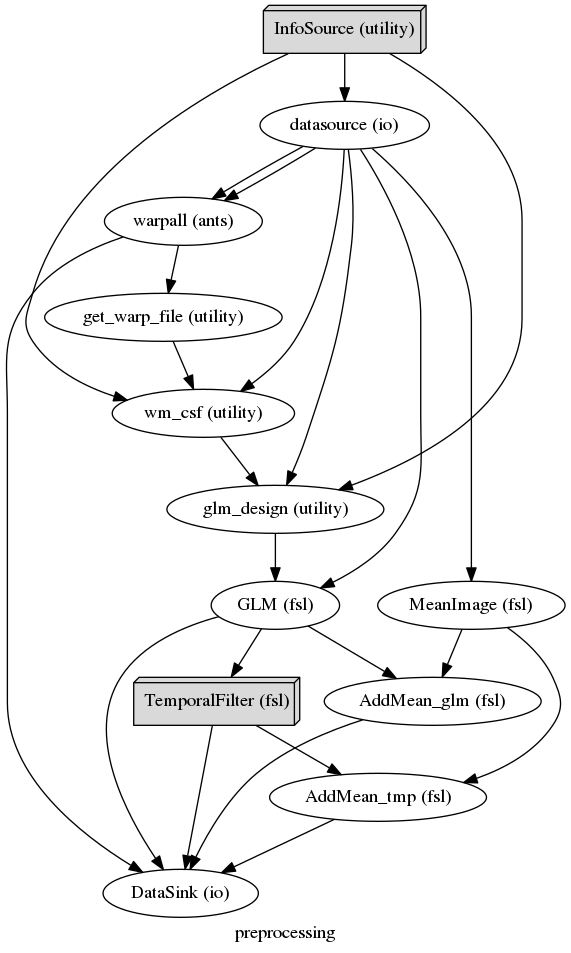

In [8]:
# Load png image
Image(os.path.join(data_out_dir, 'workflow_graph.png'))

**Question:** Where is the temporal filtered and demeaned image stored? Write down the path to it and name your variable as `path_to_processed_image`. We are going to need this below.

In [9]:
#preprocessed_image_path = os.path.join(data_out_dir, 'preprocessing_out', 'tmp_filt', '_subject_id_100307', '_highpass_sigma_17.36_lowpass_sigma_6.94', 'residuals_filt.nii.gz')
preprocessed_image_path = os.path.join(data_out_dir, 'preprocessing_out', 'glm', '_subject_id_100307', 'residuals.nii.gz')
filtered = True

## Extract ROIs from the preprocessed data

**Question:** Use the code from the 1st python notebook to extract the ROIs for the preprocessed data. The idea is the same as from the 1st noteboook. You are supposed to iterate over the regions, find their intensities and then extract the time series from the resting state image. However, this time you will pass the image of interest, the lookuptable and the segmentation image as an argument. To do this transform your code into a function.  The function should that take the image from where the time series will be extracted as input and returns the average time series series.

In [15]:
def extract_roi(subject, image_of_interest, lookuptable, segmentation_image_data, filtered):
    ntpoints = image_of_interest.shape[3]
    mask = np.zeros((image_of_interest.shape[0], image_of_interest.shape[1], image_of_interest.shape[2]))
    avg = np.zeros((lookuptable['intensity'].shape[0], ntpoints))

    for region in range(len(lookuptable)):
        intensity = lookuptable['intensity'][region]
        boolean_region = np.isclose(segmentation_image_data, intensity, atol=.0)
        boolean_mask = np.where(boolean_region)
        mask[boolean_region] = 1
        for t in range(ntpoints):
            data = image_of_interest[:, : ,:, t]
            data = data[boolean_mask[0], boolean_mask[1], boolean_mask[2]]
            avg[region, t] = data.mean()
            
    if filtered:
        savePath = os.path.join(dat_out_dir, 'extract_rois', 'filtered', 'rois_timeseries.txt')
        if not os.path.exists(savePath):
            os.makedirs(savePath)
        np.savetxt(savePath, avg, delimiter=',', fmt='%5e')
    else:
        savePath = os.path.join(dat_out_dir, 'extract_rois', 'filtered', 'rois_timeseries.txt')
        if not os.path.exists(savePath):
            os.makedirs(savePath)
        np.savetxt(savePath, avg, delimiter=',', fmt='%5e')
        
    return avg


Now that we have defined the function we can call it in order to extract the ROIs for both the preprocessed and not preprocessed image. Make sure you pass the full path to the processed image as done for the non_processed one.

Load the preprocessed, the non-preprocessed and the segmentation image using nibabel before you pass them to the function. Also remember to load the lookuptable.

In [13]:
non_preprocessed_image = nib.load(non_preprocessed_image_path)
non_preprocessed_image_data = non_preprocessed_image.get_data()

preprocessed_image = nib.load(preprocessed_image_path)
preprocessed_image_data = preprocessed_image.get_data()

segmentation_image = nib.load(segmentation_image_path)
segmentation_image_data = segmentation_image.get_data()

In [14]:
lookuptable = np.genfromtxt(lookuptable_file_path,
                           names='numbers, regions, intensity',
                           dtype=None,
                           delimiter=',')

In [21]:
avg_not_proprecessed = extract_roi(subject, non_preprocessed_image_data, lookuptable, segmentation_image_data, filtered)

avg_preprocessed = extract_roi(subject, preprocessed_image_data, lookuptable, segmentation_image_data, filtered)

In [20]:
avg_filtered = extract_roi(subject, preprocessed_image_data, lookuptable, segmentation_image_data, True)

In our analysis. We are concerned about how the correlation between the different ROIs change over time.

**Question:** Visualise the correlation matrix for the preprocessed and not preprocessed image using `np.corrcoef`. Do you notice any difference?

In [ ]:
# plot 2 images
plt.subplot(1, 2, 1)
plt.imshow(np.corrcoef(avg_not_proprecessed))
plt.subplot(1, 2, 2)
plt.imshow(np.corrcoef(avg_preprocessed))

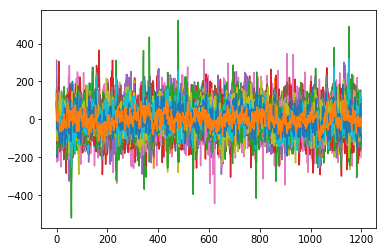

In [28]:
for i in range(avg_preprocessed.shape[0]):
    plt.plot(avg_preprocessed[i,:])

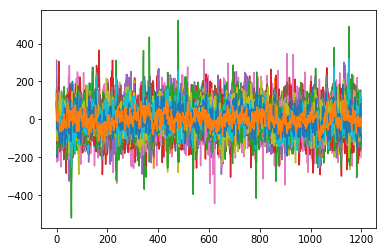

In [27]:
for i in range(avg_filtered.shape[0]):
    plt.plot(avg_filtered[i,:])

Don't forget to save the preprocessed ROIs at the end